In [1]:
import os
import random
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import visualkeras

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 15
BATCH_SIZE = 8


In [2]:
def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in tqdm(images, desc = 'images' ):
        full_path.append(os.path.join(path, i))
        
    return full_path


data_healthy = create_images_list("../Dataset/down-syndrome-classification/healty/healty")
data_down = create_images_list("../Dataset/down-syndrome-classification/downSyndorme/downSyndrome")

images:   0%|          | 0/1499 [00:00<?, ?it/s]

images:   0%|          | 0/1500 [00:00<?, ?it/s]

In [3]:
disease_classes = {0:'healthy', 1 : 'down' }

data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_healthy) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_down) , "label": 1 }) ], ignore_index = True)


data_df = shuffle(data_df).reset_index(drop = True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data_df['img'], data_df['label'], test_size = 0.15,  random_state = SEED)

print("train images: ", X_train.shape[0])
print("test images: ", X_test.shape[0])

train images:  2549
test images:  450


In [5]:
def img_preprocessing(image, label):
    
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (250,250))
    img = img/255.0
    
    return img, label

In [6]:
train_loader = tf.data.Dataset.from_tensor_slices(( X_train, y_train) )
train_dataset = (train_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(X_train.shape[0]).prefetch(BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices(( X_test, y_test) )
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE))

In [7]:
In = Input(shape=(250, 250, 3))

conv2 = Conv2D(32, 2, padding = 'same')(In)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(64, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


conv2 = Conv2D(128, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


conv2 = Conv2D(256, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

pool = GlobalAveragePooling2D()(conv2)
drop = Dropout(0.6)(pool)
dense1 = Dense(64, activation = 'relu')(drop)
dense1 = Dense(64, activation = 'relu')(dense1)
Out = Dense(1, activation = 'sigmoid')(dense1)

model = Model(inputs = In, outputs = Out)

model.compile(optimizer  = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy','AUC','Precision','Recall'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 32)      416       
                                                                 
 batch_normalization (Batch  (None, 250, 250, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      8256  

In [15]:
my_callbacks = [EarlyStopping(monitor = 'loss', patience = 8, min_delta = 0.0001)]

hist = model.fit(train_dataset, epochs = 100, verbose =1, callbacks = my_callbacks)

Epoch 1/100
319/319 [==============================] - 118s 363ms/step - loss: 0.4552 - accuracy: 0.7882 - auc: 0.8702 - precision: 0.7753 - recall: 0.8094
Epoch 2/100
319/319 [==============================] - 123s 382ms/step - loss: 0.4202 - accuracy: 0.8109 - auc: 0.8887 - precision: 0.7936 - recall: 0.8386
Epoch 3/100
319/319 [==============================] - 121s 377ms/step - loss: 0.4217 - accuracy: 0.8031 - auc: 0.8881 - precision: 0.7824 - recall: 0.8378
Epoch 4/100
319/319 [==============================] - 120s 373ms/step - loss: 0.4159 - accuracy: 0.8097 - auc: 0.8888 - precision: 0.7940 - recall: 0.8346
Epoch 5/100
319/319 [==============================] - 127s 394ms/step - loss: 0.4125 - accuracy: 0.8078 - auc: 0.8923 - precision: 0.7946 - recall: 0.8283
Epoch 6/100
319/319 [==============================] - 117s 362ms/step - loss: 0.3964 - accuracy: 0.8199 - auc: 0.8997 - precision: 0.8060 - recall: 0.8409
Epoch 7/100
319/319 [==============================] - 200s 624m

319/319 [==============================] - 110s 343ms/step - loss: 0.2648 - accuracy: 0.8839 - auc: 0.9563 - precision: 0.8695 - recall: 0.9024
Epoch 54/100
319/319 [==============================] - 111s 345ms/step - loss: 0.2653 - accuracy: 0.8874 - auc: 0.9569 - precision: 0.8755 - recall: 0.9024
Epoch 55/100
319/319 [==============================] - 111s 345ms/step - loss: 0.2714 - accuracy: 0.8803 - auc: 0.9546 - precision: 0.8749 - recall: 0.8866
Epoch 56/100
319/319 [==============================] - 110s 342ms/step - loss: 0.2503 - accuracy: 0.8937 - auc: 0.9615 - precision: 0.8828 - recall: 0.9071
Epoch 57/100
319/319 [==============================] - 112s 349ms/step - loss: 0.2507 - accuracy: 0.8921 - auc: 0.9614 - precision: 0.8878 - recall: 0.8969
Epoch 58/100
319/319 [==============================] - 293s 917ms/step - loss: 0.2622 - accuracy: 0.8886 - auc: 0.9577 - precision: 0.8804 - recall: 0.8984
Epoch 59/100
319/319 [==============================] - 4586s 14s/step 

In [16]:
test_eval = model.evaluate(test_dataset)

57/57 [==============================] - 5s 85ms/step - loss: 0.4914 - accuracy: 0.7956 - auc: 0.8964 - precision: 0.8416 - recall: 0.7391


In [17]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred_ = np.round(pred)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

57/57 [==============================] - 5s 95ms/step


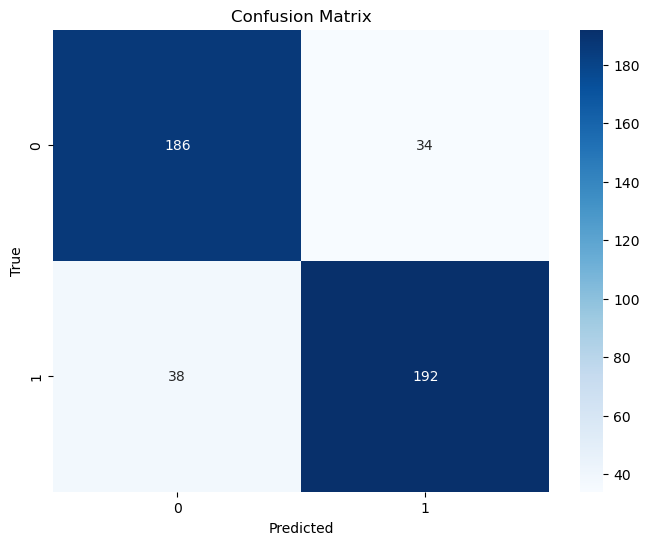

In [13]:
import seaborn as sns
cm = confusion_matrix(y_test_take, pred_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('down_cm.png')
plt.show()mu

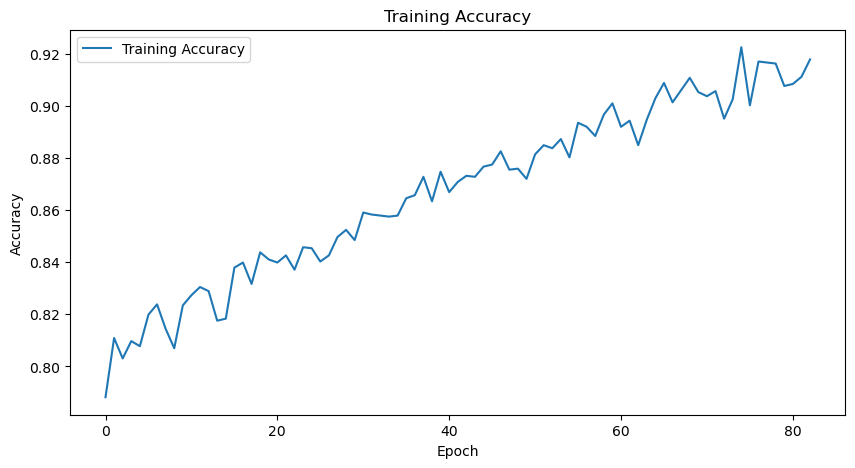

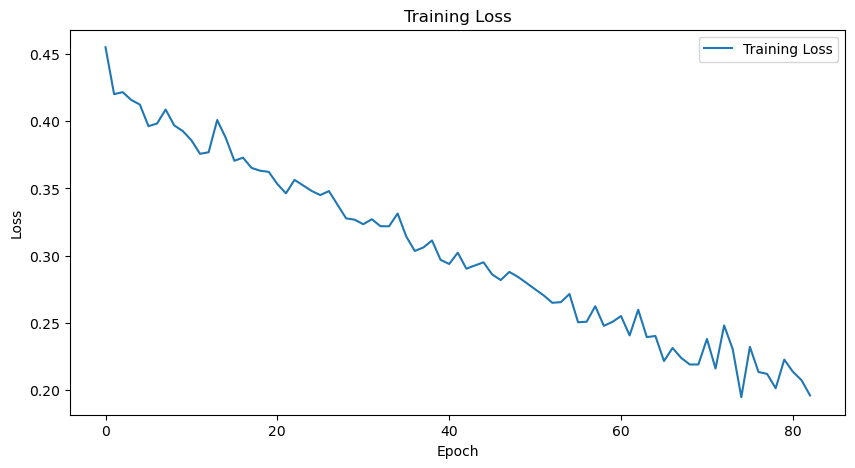

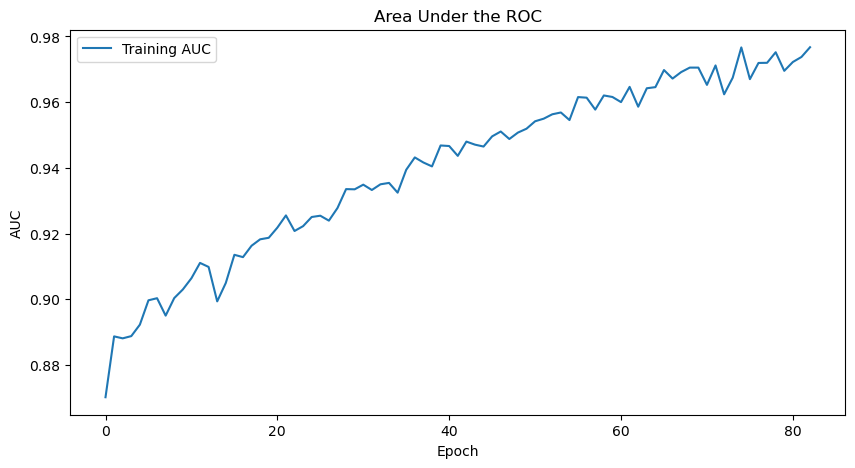

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('down_history_accuracy.png')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('down_history_loss.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(hist.history['auc'], label='Training AUC')
plt.title('Area Under the ROC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.savefig('down_history_auc.png')
plt.show()

In [19]:
cr = classification_report(np.array(y_test_take), pred_)
print(cr)

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       220
           1       0.84      0.74      0.79       230

    accuracy                           0.80       450
   macro avg       0.80      0.80      0.80       450
weighted avg       0.80      0.80      0.80       450



In [ ]:
import pickle
filename = 'down.sav'
pickle.dump(model, open(filename, 'wb'))